# Working with SeismicBatch

## Content
* [Indexing data](#Indexing-data)
* [Actions](#Actions)
    * [Load](#Load)
    * [Visualization](#Visualization)
    * [Sorting](#Sorting)
    * [Signal processing](#Signal-processing)
    * [Export](#Export)
* [Utils](#Utils)
    * [Merging files](#Merging-files)

## Indexing data

Work with seismic data starts with data indexing. See the [tutorial](./index.ipynb) on index to recall different index types. Here we consider ```FieldIndex``` that enumerates field records of two files that we will refer as ```raw``` and ```lift```:

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import medfilt 

sys.path.append('..')

from seismicpro.batchflow import Dataset
from seismicpro.src import (SeismicBatch, SegyFilesIndex, FieldIndex,
                            TraceIndex, seismic_plot, spectrum_plot,
                            merge_segy_files)

path_raw = '/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMPSCAL.sgy'
path_lift = '/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LIFT1.sgy'

field_index = (FieldIndex(name='raw', extra_headers=['offset'], path=path_raw)
               .merge(FieldIndex(name='lift', path=path_lift)))

field_index.head()

,TraceNumber,offset,TRACE_SEQUENCE_FILE,file_id,TRACE_SEQUENCE_FILE,file_id
,,,raw,raw,lift,lift
FieldRecord,,,,,,
111906,1656,35,1,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,1,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1657,36,2,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,2,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1655,78,3,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,3,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1658,79,4,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,4,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...
111906,1654,127,5,/notebooks/egor/noise_dataset_1/DN02A_LIFT_AMP...,5,/notebooks/egor/noise_dataset_1/DN02B_SHOTS_LI...


## Actions

### Load

Action ```load``` reads sets of traces from SEGY files and stores them in batch components. You can manage which components to load setting ```components``` parameter. Depending on batch index type each set of traces is represended by a signle trace (in case of ```TraceIndex```), or traces that correspond to a single field record (in case of ```FieldIndex```), or all traces from a single bin (in case of ```BinsIndex```) etc.

In each component items traces are loaded in the same order as rows in index DataFrame.

One can load not the whole trace but its specific slice. Use ```tslice``` parameter to specify which slice to load. For illustration, let's load first 3000 samples of each trace in ```raw``` and ```lift``` components:

In [2]:
batch = (Dataset(field_index, SeismicBatch).next_batch(10)
         .load(fmt='segy', components=('raw', 'lift'), tslice=slice(3000)))

Now batch contains 10 items in components ```raw``` and ```lift```. Traces in batch items have common field record id. Each trace is limited to 3000 samples.

In [3]:
batch.raw.shape, batch.lift.shape, batch.raw[0].shape

((10,), (10,), (3456, 3000))

In contrast, working with ```TraceIndex``` we will load single traces in batch items:

In [4]:
trace_batch = (Dataset(TraceIndex(field_index), SeismicBatch).next_batch(10)
              .load(fmt='segy', components=['raw', 'lift'], tslice=slice(3000)))

trace_batch.raw.shape, trace_batch.lift.shape, trace_batch.raw[0].shape

((10,), (10,), (1, 3000))

### Visualization

Below we illustrate vaious options for batch items visualization.

Show multiple traces of a single batch item with ```matplotlin.pyplot.imshow```:

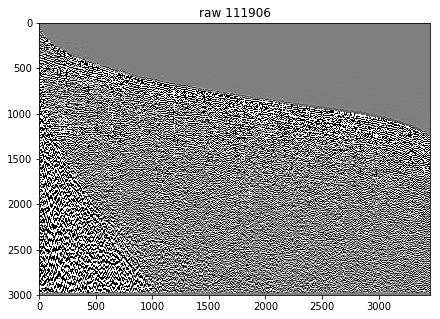

In [5]:
cv = 0.1
batch.seismic_plot('raw', batch.indices[0],
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Show multiple traces of several batch item with ```matplotlin.pyplot.imshow```:

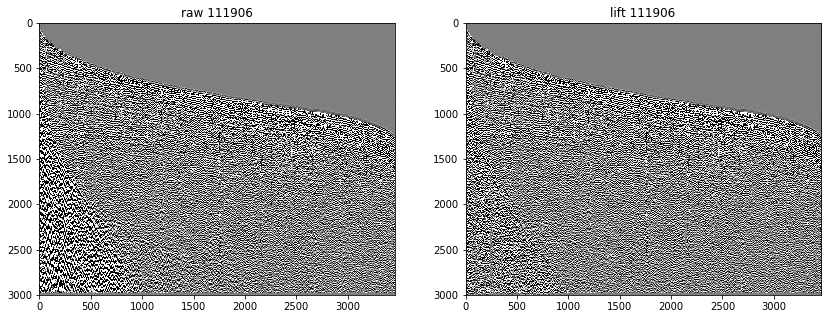

In [6]:
batch.seismic_plot(('raw', 'lift'), batch.indices[0], figsize=(14, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

Show a specific region bounded by ```xlim``` and ```ylim``` parameters:

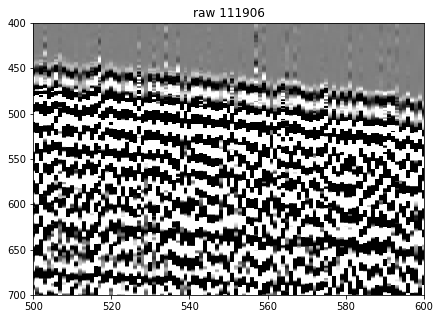

In [7]:
batch.seismic_plot('raw', batch.indices[0], xlim=(500, 600), ylim=(400, 700),
                   figsize=(7, 5), vmin=-cv, vmax=cv, cmap='gray')

Show a specific region bounded by ```xlim``` and ```ylim``` parameters in a **wingle** representation (use ```std``` parameter to control amptitudes):

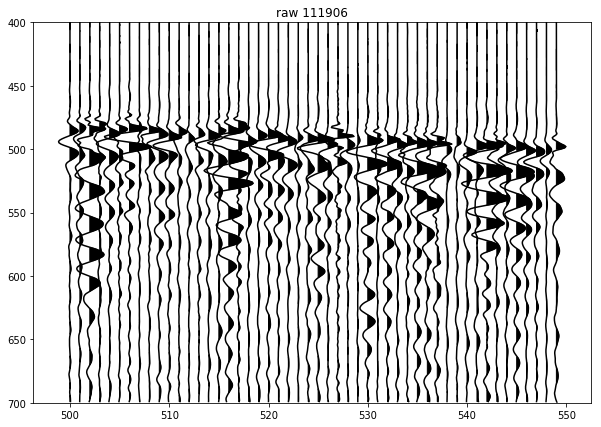

In [8]:
batch.seismic_plot('raw', batch.indices[0], wiggle=True, std=0.15,
                   xlim=(500, 550), ylim=(400, 700), figsize=(10, 7))

For batch item with a single trace ```seismic_plot``` visualize the trace with ```matplotlib.pyplot.plot``` function:

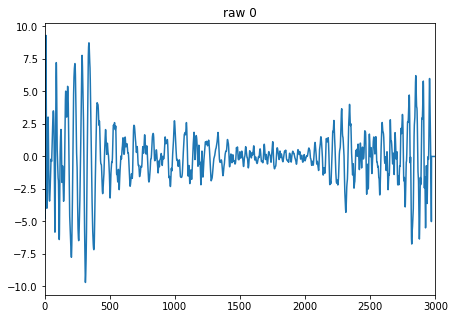

In [9]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], figsize=(7, 5))

Signle trace can also be shows in the wingle form: 

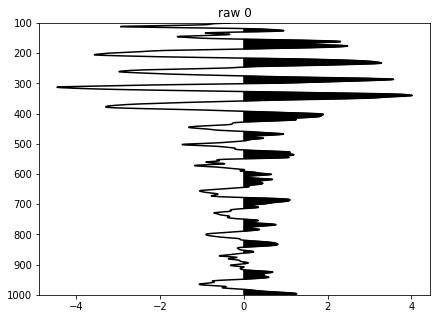

In [10]:
trace_batch.seismic_plot('raw', trace_batch.indices[0], wiggle=True,
                         ylim=(100, 1000), figsize=(7, 5))

To interactively iterate over batch items use ```items_viewer``` as follows:
```python
fig, tracker = batch.items_viewer('raw', vmin=-cv, vmax=cv, cmap='gray')
fig.canvas.mpl_connect('scroll_event', tracker.onscroll)
plt.show()
```

For investigation of signal power spectrum within selected regions use ```spectrum_plot```:

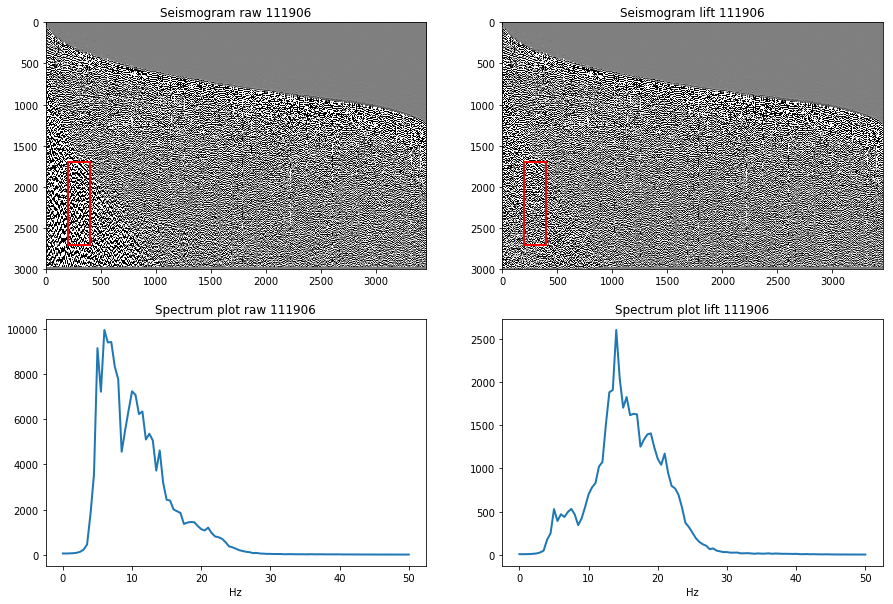

In [7]:
batch.spectrum_plot(('raw', 'lift'), batch.indices[0],
                    frame=(slice(200, 400), slice(1700, 2700)), 
                    max_freq=50, figsize=(15, 10),
                    vmin=-cv, vmax=cv, cmap='gray')

Show trace statistic such as dominant frequency (rms frequency), mean absolute amplitude, rms amplitude etc. E.g. for dominant (rms) frequency:

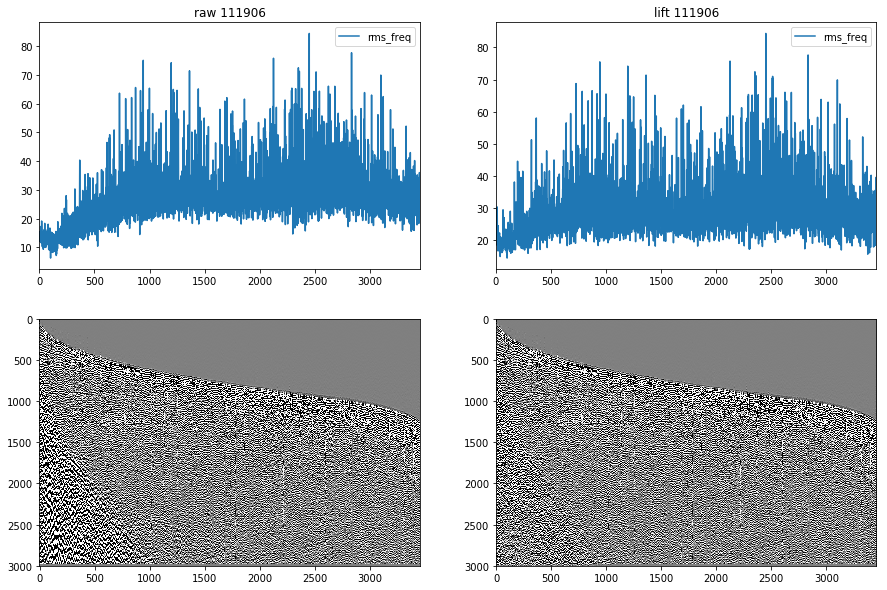

In [6]:
batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats='rms_freq', figsize=(15, 10),
                      vmin=-cv, vmax=cv, cmap='gray')

In the next plot we show both mean absolute amplitude and rms amplitude:

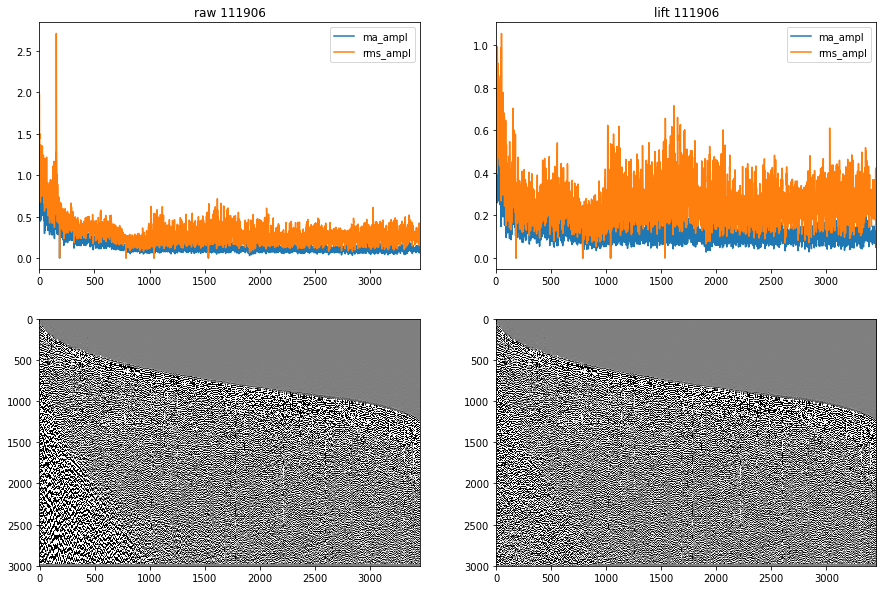

In [8]:
batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats=['ma_ampl', 'rms_ampl'],
                      figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

One can also plot custom defined statistics. E.g. consider median absolute amplitude in comparison to mean absolute amplitude:

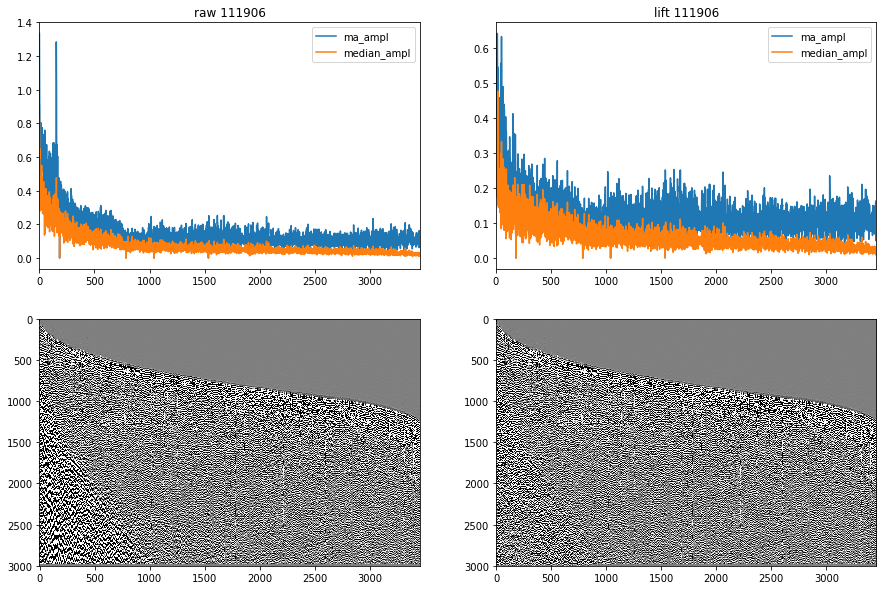

In [10]:
def median_ampl(x, *args):
    return np.median(abs(x), axis=1)

batch.statistics_plot(('raw', 'lift'), batch.indices[0], stats=['ma_ampl', median_ampl],
                      figsize=(15, 10), vmin=-cv, vmax=cv, cmap='gray')

### Sorting

Trace sorting order can be checked in components meta. By default, loaded traces have no specified order:

In [ ]:
print(batch.meta['raw']['sorting'])

Trace sorting order can be changed by ```sort_traces``` action (note this action does not affect rows order in the index DataFrame):

In [ ]:
batch.sort_traces(src='raw', dst='raw_sorted', sort_by='TraceNumber')

Check new sorting order:

In [ ]:
batch.meta['raw_sorted']['sorting']

Show traces in new sorting:

In [ ]:
batch.seismic_plot('raw_sorted', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Signal processing

There is a number of built-in signal processing methods that can be applied to traces, e.g. Fourier transform, gradient or various wavelet transforms. E.g. consider gradient and Fourier transform:

In [18]:
batch.gradient(src='raw', dst='grad_raw')
batch.rfft(src='raw', dst='fft_raw')

Besides built-in methods, any custom fuction can be applied either to axix of batch item (```apply_along_axis```) or to the whole batch item (```apply_transform```). For exmaple, consider median filtration ```scipy.signal.medfilt```:

In [19]:
batch.apply_transform(medfilt, kernel_size=(9, 1), src='raw', dst='medfilt')

Show the filtered seismogram:

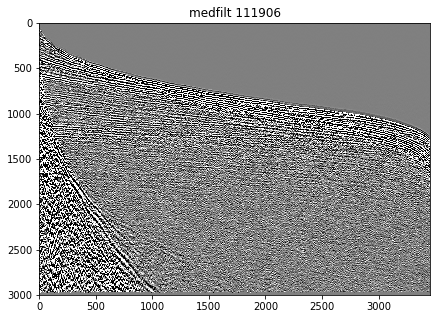

In [20]:
batch.seismic_plot('medfilt', 111906, figsize=(7, 5),
                   vmin=-cv, vmax=cv, cmap='gray')

### Export

Data in batch components can be dumped in a number of formats:
 * SEGY file
 * first-break picking text file. 

There are two options for export in SEGY files: dump each component item in a separate file (parameter ```split=True```) or dump all traces in a single file (parameter ```split=False```). The next example demonstrates how to export field record in separate files:

In [21]:
dump_path = '/notebooks/egor/geolog/notebooks/dumps/'

batch.dump(fmt='segy', path=dump_path, src='raw', split=True)

## Utils

### Merging files

```merge_segy_files``` and ```merge_spicking_files``` allow merging of a set of files into one file. For examples, let's merge all SEGY files from the ```dump_path``` exploited above:

In [22]:
merge_segy_files(path=os.path.join(dump_path, '*sgy'),
                 output_path='/notebooks/egor/geolog/notebooks/merged.sgy')

Enjoy!